Adit Mehta <br>
Adit Misar <br>
Alex Blum <br>

May 5, 2020

# Concrete Compressive Strength

### Import libraries

In [59]:
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# general math
import pandas as pd
import numpy as np
from math import sqrt
from statistics import variance, mean
# evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# model building
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn import linear_model as lm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
# machine learning
import talos
from talos.utils import lr_normalizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Nadam
from keras.losses import mse, mae
from keras.activations import softmax, sigmoid, relu, elu

from helper_functions import show_model_accuracy, show_feature_scores, plot_features_vs_response

#import warnings; warnings.simplefilter('ignore')

### Adjust settings

In [60]:
# make sure that printing shows all of the data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#plt.close('all') # close all open figures

# 1. Exploratory Data Analysis

## Organize Data

### Load the dataset and look at summary statistics

In [61]:
df = pd.read_csv("Concrete_Data.csv")  # Load dataset
# print(df.describe().T)                 # the .T transposes the data frame
# df.head()                              # head is a method!
# print('\n')
# print('Datapoints in each row:')
# print(df.count())
n_independent = 8                    # number of independent variables

### Scale the data

In [62]:
# scale the data
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

### Check for and remove duplicates

In [63]:
df = df.drop_duplicates()
duprows = df[df.duplicated()]
# duprows.head() # if table is blank, all duplicates have been removed

### Scatter plot of each feature vs response variable

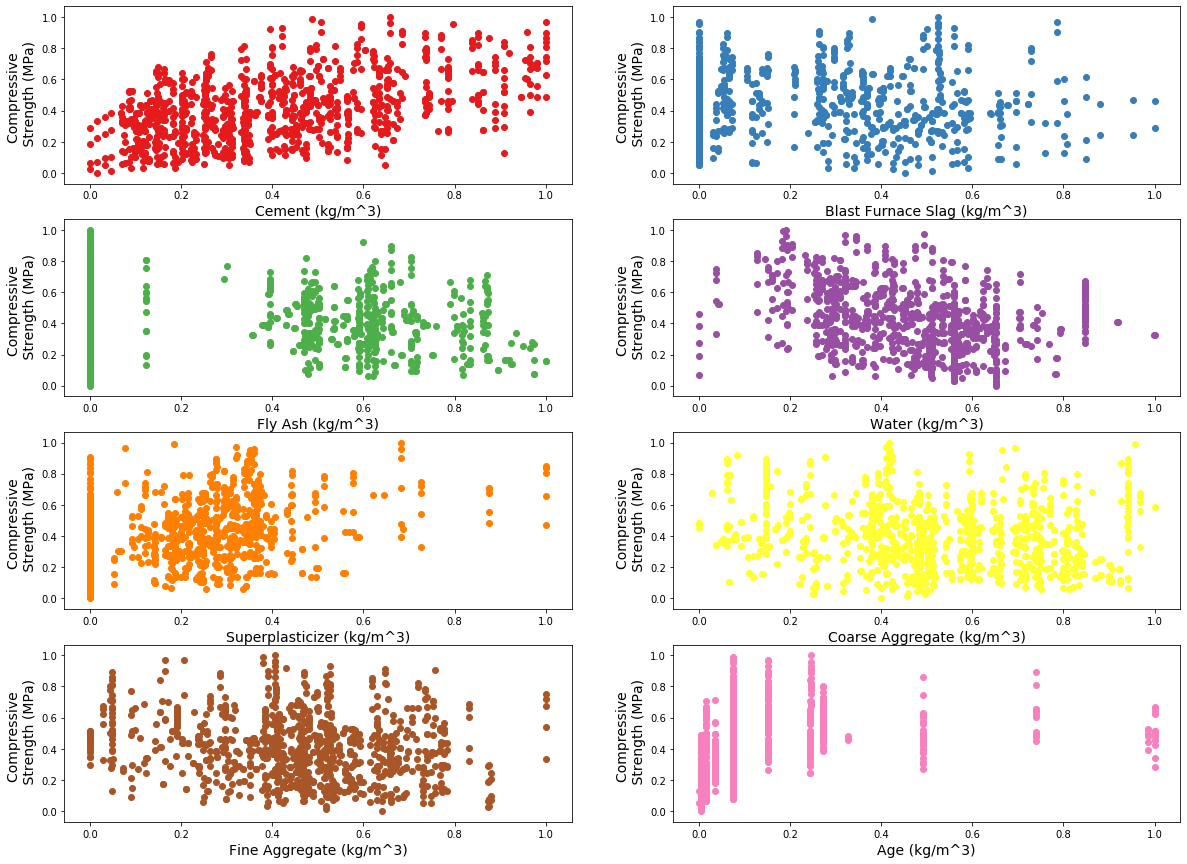

In [64]:
plot_features_vs_response(df, n_independent)

### Conclusions from plots

Strong positive relationship with cement, weaker positive relationship with superplasticizer. The relationship between compressive strength, coarse aggregate, fine aggregate, fly ash, and water content over the ranges given is weak. Age seems to have a nonlinear relationship with strength.

### Feautures where compressive strength varies at 0

In [65]:
df[df == 0].count(axis=0)

Cement (component 1)(kg in a m^3 mixture)                  4
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    470
Fly Ash (component 3)(kg in a m^3 mixture)               541
Water  (component 4)(kg in a m^3 mixture)                  5
Superplasticizer (component 5)(kg in a m^3 mixture)      378
Coarse Aggregate  (component 6)(kg in a m^3 mixture)       4
Fine Aggregate (component 7)(kg in a m^3 mixture)         30
Age (day)                                                  2
Concrete compressive strength(MPa, megapascals)            1
dtype: int64

Number of Zeros for Each Category
<ul>
  <li>Fly Ash - 541</li>
  <li>Superplasticizer - 378</li>
  <li>Blast Furnace Slag - 470</li>
</ul>
Conclusion: compressive strength does not have a strong dependence on fly ash, superplasticizer, or slag.

### Organize data for input into sklearn algorithms

In [66]:
X = df.iloc[:,0:n_independent] # scaled inputs. we go 0 to 8 b/c it only counts n-1
y = df.iloc[:,-1]  # scaled outputs (measured)

### Remove features with weak correlation
####  Check features for significance, then remove least significant variables

In [67]:
show_feature_scores(X,y)

        Score                                       Feature Name
0  313.999951          Cement (component 1)(kg in a m^3 mixture)
1   10.834031  Blast Furnace Slag (component 2)(kg in a m^3 m...
2    6.566344         Fly Ash (component 3)(kg in a m^3 mixture)
3   78.631478          Water  (component 4)(kg in a m^3 mixture)
4  134.807107  Superplasticizer (component 5)(kg in a m^3 mix...
5   21.455326  Coarse Aggregate  (component 6)(kg in a m^3 mi...
6   36.122938  Fine Aggregate (component 7)(kg in a m^3 mixture)
7  128.819696                                          Age (day)


In [68]:
X.drop(X.columns[[1,2,5,6]], axis=1, inplace=True)
show_feature_scores(X,y)

        Score                                       Feature Name
0  313.999951          Cement (component 1)(kg in a m^3 mixture)
1   78.631478          Water  (component 4)(kg in a m^3 mixture)
2  134.807107  Superplasticizer (component 5)(kg in a m^3 mix...
3  128.819696                                          Age (day)


### Hold back 20% of data for validating the final models

In [57]:
# 0. set aside 20%? of the data for final validation
X_train, X_final_val, y_train, y_final_val =  train_test_split(X, y, 
                                                               test_size = 0.2)

# repeat the below steps ten times
# 1. break the data into 90% - fold training, 10% fold validation
rkf = RepeatedKFold(n_splits, n_repeats)

for train_index, test_index  in rkf.split(X):
    # split into train and test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # fit the data to the model
    regr_linear.fit(X_train, y_train)
    y_pred = regr_linear.predict(X_test)
    # save coefficients to array
    coeffs = np.append(coeffs,  regr_linear.coef_)
    # check model accuracy
    r2_value.append(r2_score(y_test, y_pred))
    RMSE.append(sqrt(mean_squared_error(y_pred, y_test)))

# 2. tune hyperparameters through 5-fold rotating validation
# 3. check the best hyperparameters on the fold validation data

# after ten repetitions, compare the ten models and choose the best one

# 2. Machine Learning Models

## K-Fold Parameters

In [69]:
n_splits = 10
n_repeats = 10
rkf = RepeatedKFold(n_splits, n_repeats)

## 2.1 Multilinear Regression

In [70]:
regr_linear = lm.LinearRegression() # linear model
regr_linear.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
'''What types of analysis /checks can I do with the scores that I get from the outer K folds?

check for stability of the predictions (use iterated/repeated cross-validation)
check for the stability/variation of the optimized hyper-parameters.'''

'What types of analysis /checks can I do with the scores that I get from the outer K folds?\n\ncheck for stability of the predictions (use iterated/repeated cross-validation)\ncheck for the stability/variation of the optimized hyper-parameters.'

In [84]:
r2_value = []
RMSE = []
coeffs = np.empty((1,4),dtype=float)

for train_index, test_index  in rkf.split(X):
    # split into train and test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # fit the data to the model
    regr_linear.fit(X_train, y_train)
    y_pred = regr_linear.predict(X_test)
    # save coefficients to array
    # rc_array =  np.asarray([regr_linear.coef_])
    coeffs = np.append(coeffs, np.asarray([regr_linear.coef_]), axis=1)
    # check model accuracy
    r2_value.append(r2_score(y_test, y_pred))
    RMSE.append(sqrt(mean_squared_error(y_pred, y_test)))

[[0.36326221 0.21778923 0.30811446 0.46268095]]


[ 0.35998467 -0.21264207  0.30829338  0.47186135  0.36656707 -0.2449482
  0.27076911  0.46201733  0.36600688 -0.24237302  0.27425854  0.48047349
  0.36836014 -0.23280375  0.29508738  0.49134695  0.38910677 -0.21760312
  0.29853398  0.47986059  0.36164271 -0.24205971  0.27931978  0.47174856
  0.36022983 -0.21973968  0.27970117  0.47510274  0.35956482 -0.26253357
  0.28766695  0.4980309   0.35647209 -0.22020961  0.28657262  0.48112853
  0.36152058 -0.23245192  0.27495305  0.46181967]


In [35]:
show_model_accuracy(r2_value, RMSE, n_repeats)

Mean of r^2 for all data: 0.4747
Variance of r^2 for all data: 0.0053
Mean of RMSE for all data: 0.1462
Variance of RMSE for all data: 0.0001 

Fold: 1
         r2      RMSE
0  0.448637  0.131678
1  0.577664  0.129348
2  0.515624  0.135429
3  0.531875  0.156037
4  0.283127  0.176866
5  0.543470  0.134192
6  0.491054  0.155540
7  0.418304  0.156596
8  0.510484  0.138625
9  0.398668  0.151940
Mean of r^2: 0.4719
Variance of r^2: 0.0076
Mean of RMSE: 0.1466 

Variance of RMSE: 0.0002 

Fold: 2
          r2      RMSE
10  0.381571  0.158774
11  0.350549  0.151754
12  0.441853  0.139789
13  0.481304  0.160328
14  0.435795  0.153458
15  0.509727  0.144978
16  0.540602  0.143322
17  0.553704  0.132928
18  0.600321  0.122274
19  0.527462  0.147058
Mean of r^2: 0.4823
Variance of r^2: 0.0063
Mean of RMSE: 0.1455 

Variance of RMSE: 0.0001 

Fold: 3
          r2      RMSE
20  0.440025  0.152797
21  0.433354  0.147966
22  0.560008  0.138841
23  0.455954  0.153671
24  0.364599  0.160936
25  0.45466

### Compare results above with cross_val_score

In [56]:
'''cvscores = -cross_val_score(regr_linear, X, y, 
                           scoring='neg_mean_squared_error', cv=10)

for i in np.nditer(cvscores, op_flags=['readwrite']):
    i[...]=sqrt(i)

print(cvscores)
print(mean(cvscores))'''

[0.13856768 0.1460583  0.13888523 0.13972652 0.16395034 0.13154915
 0.1463655  0.16012171 0.15403635 0.14791212]
0.1467172906970718


In [55]:
#cvscores = cross_val_score(regr_linear, X, y, 
                           scoring='r2', cv=10)

#print(cvscores)
#print(mean(cvscores))

[0.52622961 0.52204571 0.49234471 0.47034168 0.30708268 0.53814753
 0.53866052 0.47913788 0.39411223 0.45519983]
0.4723302391901315


In [ ]:
ypred = regr_linear.fit(X, y)
x_plot = np.arange(0, np.size(y_plot, axis=0))
f = plt.figure(figsize=(20, 15))
plt.scatter(x_plot, y_plot)
yscaled = preprocessing.minmax_scale(y)
plt.scatter(x_plot, yscaled)
plt.legend(['prediction of scaled data', 'observed data'])

In [ ]:
RGB = np.array([[[228,26,28]], [[55,126,184]], [[77,175,74]], [[152,78,163]], 
                [[255,127,0]], [[255,255,51]], [[168,86,40]], [[247,129,191]]])
RGB = np.divide(RGB, 255)
xlabels = ['Cement (kg/m^3)', 'Water (kg/m^3)', 'Superplasticizer (kg/m^3)', 'Age (kg/m^3)'] 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
ax = ax.flatten()
Xplot = np.array(X.iloc[:,0:n_independent])
yplot = np.array(df.iloc[:,-1])
for ii in range(0, np.size(ax)):
    ax[ii].scatter(Xplot[:,ii], yplot, c=RGB[ii][:])
    ax[ii].set_ylabel('Compressive \n Strength (MPa)',fontsize=14)
    ax[ii].set_xlabel(xlabels[ii],fontsize=14)

### Check the model using withheld validation data

In [52]:
y_pred = regr_linear.predict(X_validate)
# check model accuracy
print(r2_score(y_validate, y_pred))
print(sqrt(mean_squared_error(y_pred, y_validate)))

0.47812953440373374
0.14357028740456798


## 2.2 Decision Tree

In [ ]:
regr_dec_tree = DecisionTreeRegressor(max_depth=64)

In [ ]:
r2_value = []
RMSE = []
for train_index, test_index  in rkf.split(X):
    # split into train and test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # fit the data to the model
    regr_dec_tree.fit(X_train, y_train)
    y_pred = regr_dec_tree.predict(X_test)
    # check model accuracy
    r2_value.append(r2_score(y_test, y_pred))
    RMSE.append(sqrt(mean_squared_error(y_pred, y_test)))

In [ ]:
show_model_accuracy(r2_value, RMSE, n_repeats)

In [ ]:
print(X_validate.iloc[:,0])

In [ ]:
# check model accuracy
print(r2_score(y_validate, y_pred))
print(sqrt(mean_squared_error(y_pred, y_validate)))

f = plt.figure(figsize=(20, 15))
plt.plot(X.iloc[:,0], y, 'o')
plt.plot(X_validate.iloc[:,0], regr_dec_tree.predict(X_validate), 's')

plt.xlabel('Cement',fontsize=30)
plt.ylabel('Compressive Strength',fontsize=30)
plt.legend(['prediction of scaled data', 'observed data'],
          fontsize=30)

f = plt.figure(figsize=(20, 15))
plt.plot(X.iloc[:,1], y, 'o')
plt.plot(X_validate.iloc[:,1], regr_dec_tree.predict(X_validate), 's')

plt.xlabel('Water',fontsize=30)
plt.ylabel('Compressive Strength',fontsize=30)
plt.legend(['predicted', 'observed'],
          fontsize=30)

## 2.3 Artifical Neural Networks

In [ ]:
def concrete_strength_model(X_train, y_train, X_validate, y_validate, params):
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=X.shape[1], 
                    kernel_initializer=params['kernel_initializer'], 
                    activation=params['activation']))
    
    model.add(Dropout(params['dropout_rate']))

    # if we want to also test for number of layers and shapes, that's possible
    # hidden_layers(model, params, 1)
    
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))

    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  metrics=['mse', talos.utils.metrics.rmse])
    
    history = model.fit(X_train, y_train, 
                        validation_data=[X_validate, y_validate],
                        batch_size=params['batch_size'],
                        #callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)
    
    return history, model

In [ ]:
p = {'lr': (0.1, 5, 10), # (min, max, nsteps)
     'first_neuron':[4,8,16],
     'hidden_layers':[0, 1, 2], 
     'batch_size': [10, 20, 40, 60, 80, 100],
     'epochs': [10, 50],
     'dropout_rate': [0.1, 0.2, 0.3],
     'kernel_initializer': ['uniform','normal'],
     'optimizer': [Nadam, Adam], # calling this way uses default values
     'losses': ['mse', 'mae'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid'],
     'weight_regulizer': [None]}

In [ ]:
Xarray = X.to_numpy()
yarray = y.to_numpy()

In [ ]:
# and run the experiment
t = talos.Scan(Xarray,
               yarray,
               params=p,
               model=concrete_strength_model,
               fraction_limit=.01,
               experiment_name='concrete_strength',
               reduction_metric='rmse')

In [ ]:
# accessing the results data frame
t.data.head()# accessing epoch entropy values for each round
t.learning_entropy

In [ ]:
# access the summary details
t.details

In [ ]:
# use Scan object as input
analyze_object = talos.Analyze(t)

In [ ]:
# heatmap correlation
# 2nd argument is values to exclude
print('Correlation plot with validation loss as metric')
analyze_object.plot_corr('val_loss' , ['acc', 'rmse', 'val_mse', 'mse', 'val_loss'])

In [ ]:
analyze_object.plot_box('lr','val_rmse', hue='losses')
plt.xlabel('Learning Rate', fontsize=20)
plt.ylabel('Validation RMSE',fontsize=20)